## Time to get your hands dirty! Supernova distances and redshifts (part 1)

Measuring the cosmological relationship between distance and redshift is at the heart of the entire field of cosmology and allowed, among other things, the discovery of dark energy! At high redshifts, this is done with Type Ia Supernova which are standard (or better, standardizable) candles.

This is a [Nobel prize](https://www.nobelprize.org/prizes/physics/2011/riess/facts/) plot by [Riess et al](https://iopscience.iop.org/article/10.1086/300499)

Let's recall the definition of magnitude and the distance modulus (ah! the astronomers...)

$$
\mu = m-M =  5 \log_{10}\left(\frac{d_L}{\rm pc}\right) - 5
$$

Here is the Hubble diagram for Type Ia supernovae (which are standard candels). The lines show the predictions for cosmologies with varying amounts of Ωm and ΩΛ. The observed points all lie above the line for a universe with zero Λ. The lower panel, with the slope caused by the inverse square law taken out, shows the difference between the predictions more clearly and shows why a model with ΩΛ > 0 is favored. 

These are some (synthetic but realistic; see textbook) supernova data

(35.0, 50.0)

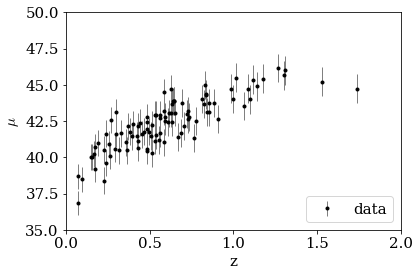

In [18]:
import matplotlib.pyplot as plt
import scipy

from astroML.datasets import generate_mu_z
z_sample, mu_sample, dmu = generate_mu_z(100, random_state=1234)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50)

####  Tasks

- First, explore fitting this data with the tecniques we have seen.
- Start from linear regression and polynomial regression
- For the case of  polynomial regression, just fit many of them for now.
- Let's bet based on intuition! Which fit is the best?
- In what cases are you underfitting the data?
- In what cases are you overfitting the data?
- Now split the data into training and validation sets
- Implement a cross-validation procedure
- Pick the best!
- Does it agree with our bets?

#### If you have time (or later at home...)

- Repeat with Basis Function Regression and Kernel Regression
- Explore what happens when you change the number of datapoints and plot the resulting learning curves.

-------
## My implementation

In [124]:
import numpy as np


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from astropy.cosmology import FlatLambdaCDM
from astroML.linear_model import PolynomialRegression
from astroML.linear_model import BasisFunctionRegression
from astroML.linear_model import NadarayaWatson


plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.serif'] = ['Liberation Serif'] + plt.rcParams['font.serif']
plt.rcParams['font.size']=15

color = ['#F5793A', '#A95AA1', '#85C0F9', '#0F2080']

In [128]:
''' computes the rms error'''
def rms_error(x, y, clf):
    return np.sqrt(np.sum((clf.predict(x) - y) ** 2)/ len(y))


'''
given a classifier with an hyperparameter, it computes the trianing and cv error doing kfold cross validation
and a median for the errors obtained at each K cycle
'''
def errors_cv(X, y, dy, clf, cv, random_state):
    kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
    cverr = []
    trainerr = []
    
    for train_index, cv_index in kf.split(X):
        X_train, X_cv = X[train_index], X[cv_index]
        y_train, y_cv = y[train_index], y[cv_index]
        dy_train, dy_cv = dy[train_index], dy[cv_index]
        
        clf.fit(X_train, y_train, dy_train)
        trainerr.append(rms_error(X_train, y_train, clf))
        cverr.append(rms_error(X_cv, y_cv, clf))
    
    return np.median(cverr), np.median(trainerr)


'''
plots the learning curves and the mean of data uncertainties 
'''
def learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, clf):
    cverr_dbest =[]
    trainerr_dbest =[]
    N = np.arange(1, len(X_train))

    for n in N:
    
        clf.fit(X_train[:n][:,np.newaxis], y_train[:n], dy_train[:n])
        cverr_dbest.append(rms_error(X_cv[:,np.newaxis], y_cv, clf))
        trainerr_dbest.append(rms_error(X_train[:n][:,np.newaxis], y_train[:n], clf))

    plt.plot(N, cverr_dbest, color[2], label='cv')
    plt.plot(N, trainerr_dbest, color[0], label='train')
    plt.hlines(np.mean(np.concatenate((dy_train, dy_cv))), min(N), max(N), color=color[1], 
               linestyle='--',
               label='mean of uncertainties')
    
    plt.xlabel('Ntrain')
    plt.ylabel('rms error')
    plt.legend()
    
    return 0;

### Theroetical model

/usr/local/lib/python3.9/site-packages/astropy/cosmology/flrw.py:1280: RuntimeWarning: divide by zero encountered in log10
  val = 5. * np.log10(abs(self.luminosity_distance(z).value)) + 25.0


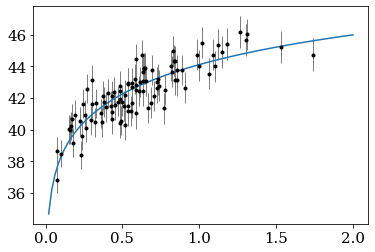

In [71]:
# Model
def distmodz(par, z):
    H0, Om = par
    
    # Flat universe model
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om)
    
    # distance modulus in magnitudes
    mu_predicted = cosmo.distmod(z).value
    return mu_predicted


# Theoretical model
zgrid = np.linspace(0,2,100)
p0 = [71, 0.27]
mumodel = distmodz(p0, zgrid)

plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='observations')
plt.plot(zgrid, mumodel)

### Linear regression

slope and intercept:  [4.5911933] 39.604564811058694


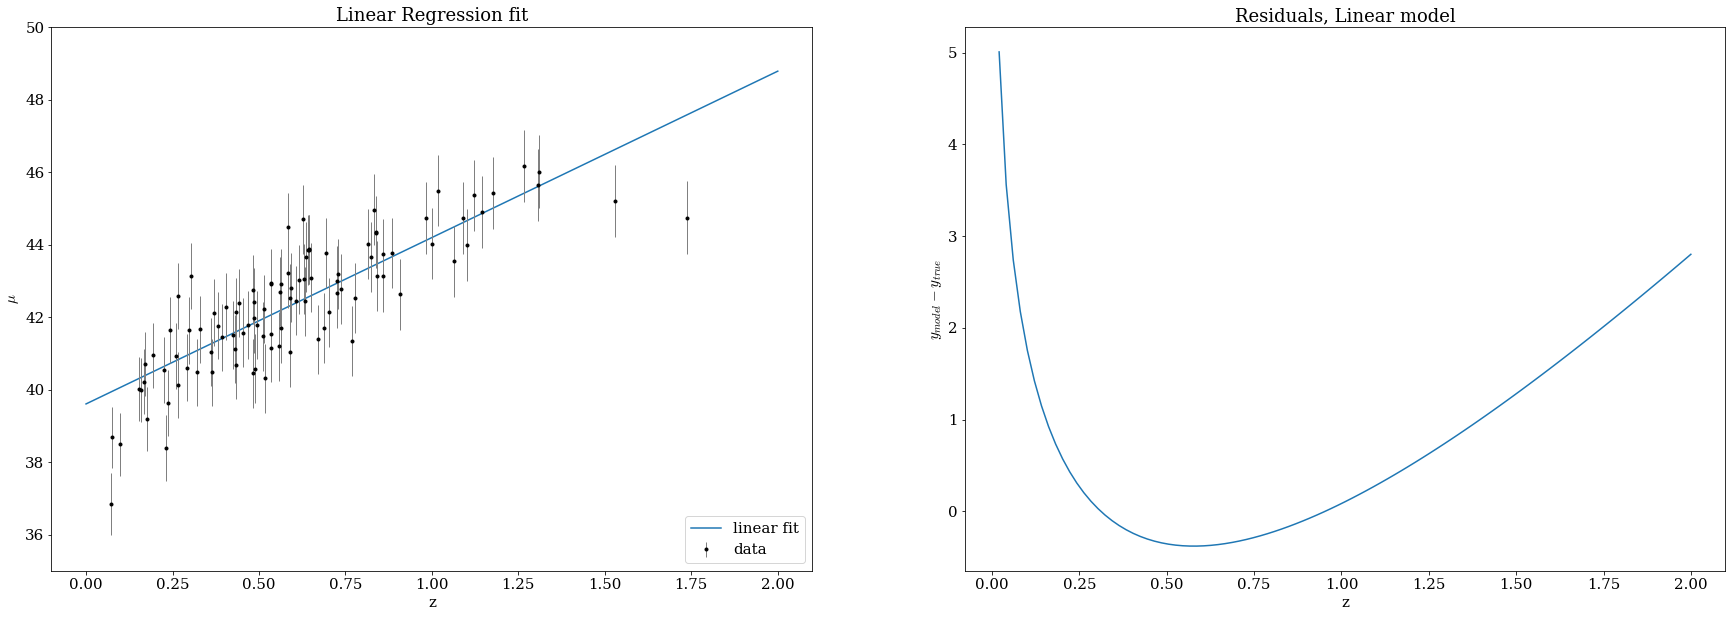

In [99]:
# Linear regression fit
reg = LinearRegression()
reg.fit(z_sample[:,np.newaxis], mu_sample, dmu)

# Parameters
theta0 = reg.coef_
theta1 = reg.intercept_
print('slope and intercept: ', theta0, theta1)

# Plot the fit
yfit = reg.predict(zgrid[:,np.newaxis])

fig = plt.figure(figsize=(30,10))

ax1 = fig.add_subplot(121)
plt.plot(zgrid, yfit, label='linear fit')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
#plt.xlim(0,2)
plt.ylim(35,50)
plt.title('Linear Regression fit');

ax2 = fig.add_subplot(122)
plt.plot(zgrid, yfit-mumodel)
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals, Linear model');

### Polynomial Regression

Do polynomioal regression with d = 1,2,3,4,5,7,10,13 in two different canvas (to see them clearer).

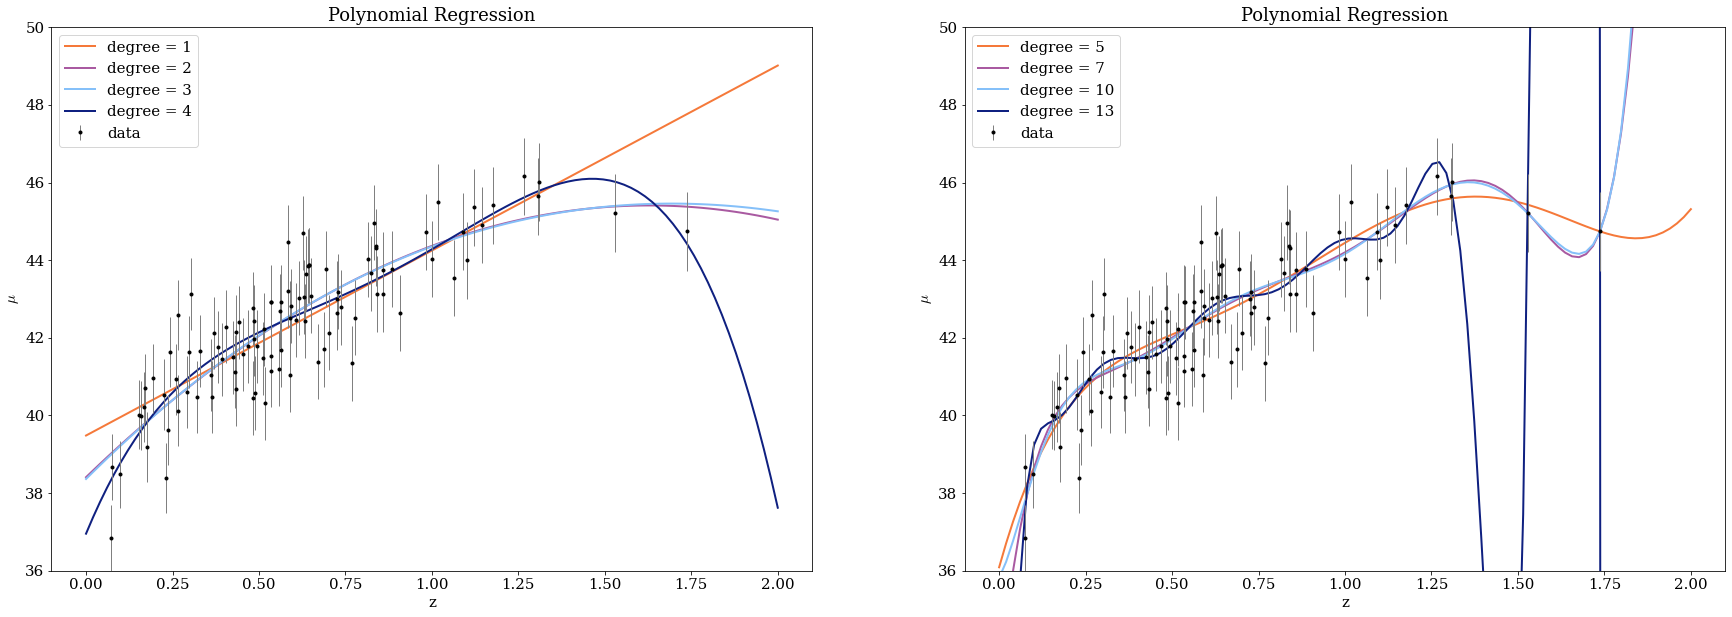

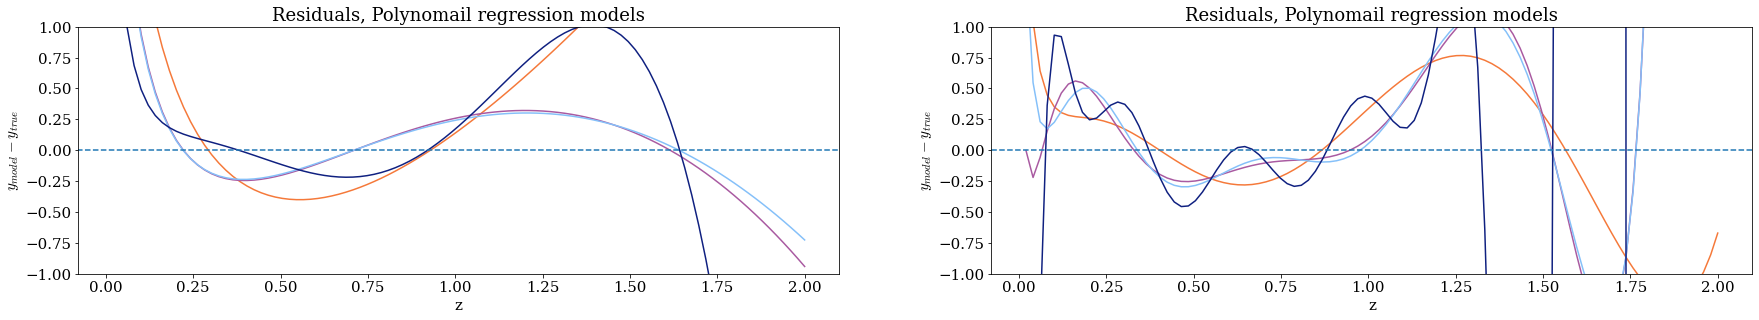

In [113]:
xgrid = np.linspace(0, 2, 100)

fig = plt.figure(figsize=(30,10))
ax1 = fig.add_subplot(121)


degree_low = np.linspace(1, 4, 4,  dtype=int)
degree_high = np.linspace(5, 13, 4,  dtype=int)

for i,d in enumerate(degree_low):
    model = PolynomialRegression(d)
    model.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit = model.predict(xgrid.reshape(-1,1))
    ax1.plot(xgrid, yfit, label='degree = ' + str(d), color=color[i], lw=2)

ax1.set_title('Polynomial Regression')
ax1.set_xlabel("z")
ax1.set_ylabel("$\mu$")
ax1.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
ax1.legend()
ax1.set_ylim(36, 50)


ax2 = fig.add_subplot(122)

for i,d in enumerate(degree_high):
    model = PolynomialRegression(d)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    yfit = model.predict(zgrid.reshape(-1,1))
    ax2.plot(zgrid, yfit, label='degree = ' + str(d), color=color[i], lw=2)    

plt.title('Polynomial Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.legend()
plt.ylim(36, 50);



fig = plt.figure(figsize=(30,10))
ax3 = fig.add_subplot(221)
for i,d in enumerate(degree_low):
    model = PolynomialRegression(d)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    yfit = model.predict(zgrid.reshape(-1,1))
    plt.plot(zgrid, yfit-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals, Polynomail regression models');


ax4 = fig.add_subplot(222)
for i,d in enumerate(degree_high):
    model = PolynomialRegression(d)
    model.fit(z_sample[:,np.newaxis], mu_sample, dmu)
    yfit = model.predict(zgrid.reshape(-1,1))
    plt.plot(zgrid, yfit-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals, Polynomail regression models');

First impressions: for $d=1$ there is an underfitting while for $d\geq5$ it is overfitting.
For  $d\geq4$ there seems to be an overfitting due to the last two points.

##### Cross Validation

In [131]:
cverr_poly = []
trainerr_poly = []

degree = np.linspace(1, 20, 20, dtype=int)

for d in degree:
    poly = PolynomialRegression(d)
    cverr, trainerr = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, poly, 7, random_state=10)
    cverr_poly.append(cverr)
    trainerr_poly.append(trainerr)
    
d_best = degree[cverr_poly == min(cverr_poly)][0]
print('best degree:', d_best)

best degree: 2


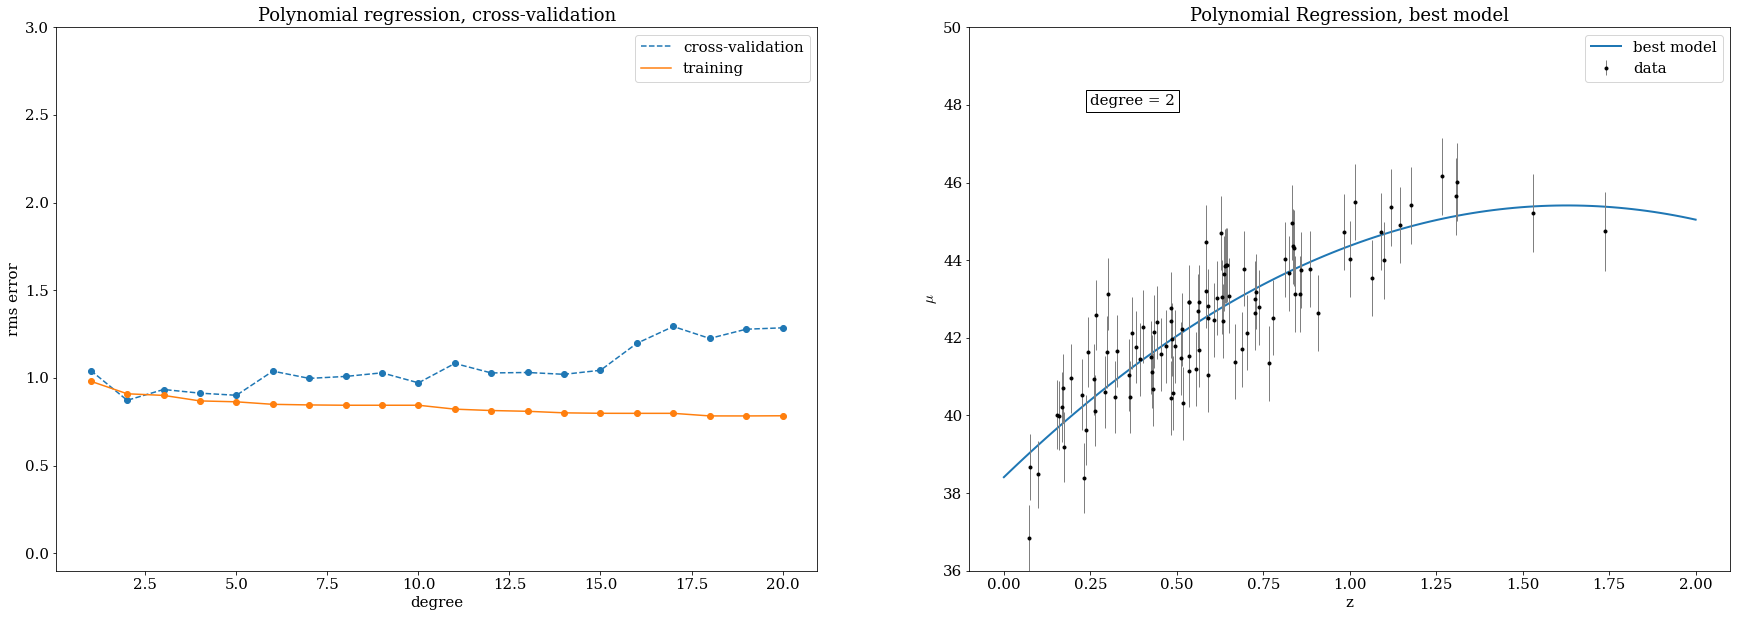

In [132]:
fig = plt.figure(figsize=(30,10))

# Plot cross-validation result
ax1 = plt.subplot(121)
plt.scatter(degree, cverr_poly)
plt.scatter(degree, trainerr_poly)
plt.plot(degree, cverr_poly, '--', label='cross-validation')
plt.plot(degree, trainerr_poly, '-', label='training')
plt.xlabel('degree')
plt.ylabel('rms error')
plt.legend();
plt.ylim(-0.1, 3.)
plt.title('Polynomial regression, cross-validation');

# plot best model
poly = PolynomialRegression(d_best)
poly.fit(z_sample[:, np.newaxis], mu_sample, dmu)
yfit = poly.predict(zgrid.reshape(-1,1))

ax2 = plt.subplot(122)
ax2.plot(zgrid, yfit, label='best model', lw=2)  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.legend()
plt.ylim(36, 50);
plt.text(0.25, 48, 'degree = '+str(d_best), bbox=dict(ec='k', fc='w'))
plt.title('Polynomial Regression, best model')
plt.xlabel("z")
plt.ylabel("$\mu$");

------------

### Basis Function Regression

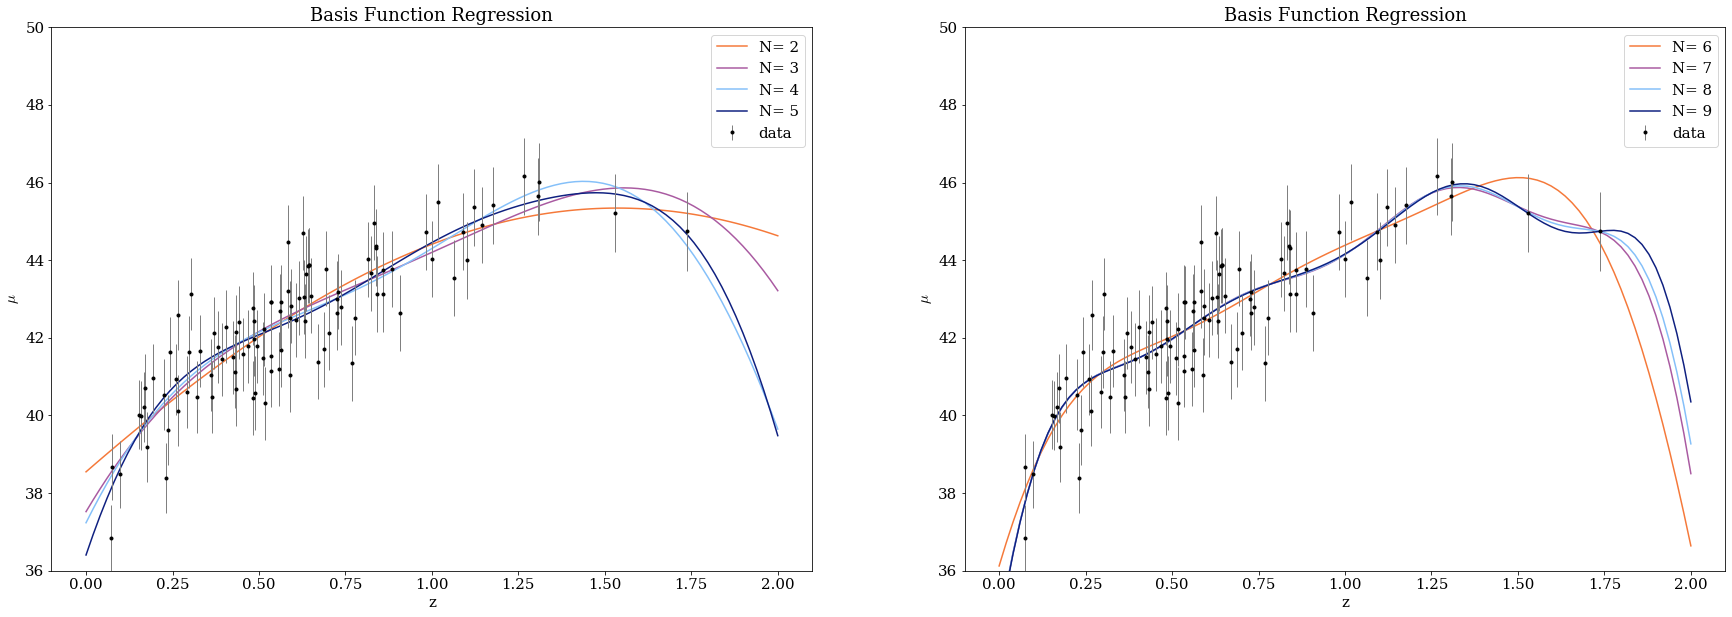

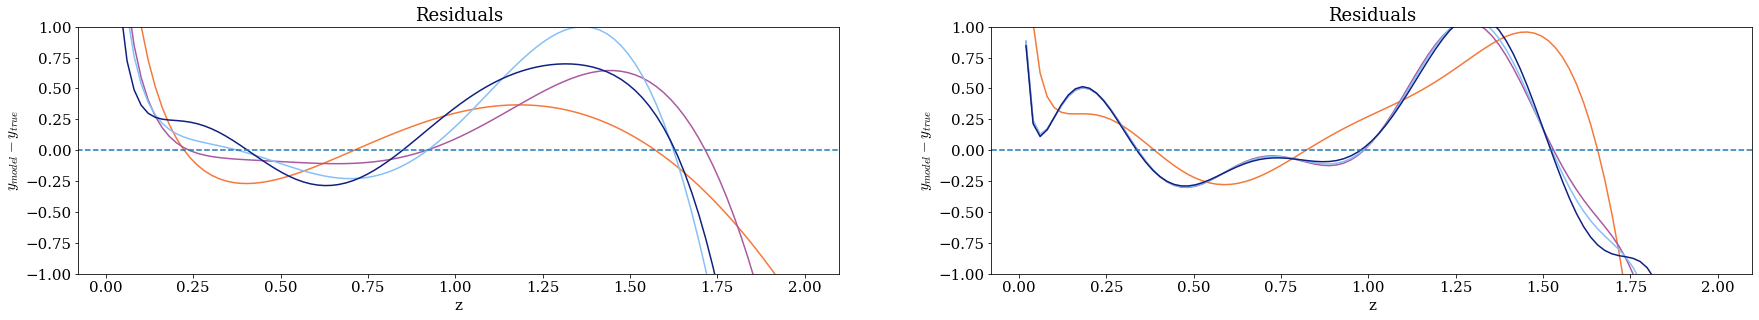

In [121]:
# example of how the fit changes as N changes & A = const= 1
xgrid = np.linspace(0, 2, 100)
fig = plt.figure(figsize=(30,10))
Nlow = np.linspace(2, 5, 4, dtype=int)    # number of gaussians
Nhigh = np.linspace(6, 9, 4, dtype=int)   # number of gaussians


ax1 = plt.subplot(121)
for i,n in enumerate(Nlow):
    basis_centers = np.linspace(0, 2, n)[:, np.newaxis]
    basis_width = basis_centers[1]-basis_centers[0]
    basis = BasisFunctionRegression('gaussian', mu=basis_centers, 
                                sigma=basis_width)
    basis.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_basis = basis.predict(xgrid[:, np.newaxis])
    plt.plot(xgrid, yfit_basis, label='N= ' + str(n), color = color[i])
    

    
plt.title('Basis Function Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.legend()
plt.ylim(36, 50)

    
ax2 = plt.subplot(122)
for i,n in enumerate(Nhigh):
    basis_centers = np.linspace(0, 2, n)[:, np.newaxis]
    basis_width = 1 * (basis_centers[1]-basis_centers[0])
    basis = BasisFunctionRegression('gaussian', mu=basis_centers, 
                                sigma=basis_width)
    basis.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_basis = basis.predict(xgrid[:, np.newaxis])
    plt.plot(xgrid, yfit_basis, label='N= ' + str(n), color = color[i])
    
plt.title('Basis Function Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.legend()
plt.ylim(36, 50)


fig = plt.figure(figsize=(30,10))
ax3 = fig.add_subplot(221)
for i,n in enumerate(Nlow):
    basis_centers = np.linspace(0, 2, n)[:, np.newaxis]
    basis_width = 1 * (basis_centers[1]-basis_centers[0])
    basis = BasisFunctionRegression('gaussian', mu=basis_centers, 
                                sigma=basis_width)
    basis.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_basis = basis.predict(xgrid[:, np.newaxis])
    plt.plot(zgrid, yfit_basis-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');


ax4 = fig.add_subplot(222)
for i,n in enumerate(Nhigh):
    basis_centers = np.linspace(0, 2, n)[:, np.newaxis]
    basis_width = 1 * (basis_centers[1]-basis_centers[0])
    basis = BasisFunctionRegression('gaussian', mu=basis_centers, 
                                sigma=basis_width)
    basis.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_basis = basis.predict(zgrid[:, np.newaxis])
    plt.plot(zgrid, yfit_basis-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');

##### Cross-Validation

In [56]:
N = np.linspace(2, 20, 19, dtype=int)    # number of gaussians
sigma = np.linspace(0.01, 2., 100)       # width

trainerr_basis = np.zeros((len(N), len(sigma)))
cverr_basis = np.zeros((len(N), len(sigma)))

for i,n in enumerate(N):
    for j,s in enumerate(sigma):
        basis_centers = np.linspace(0, 2, n)[:, np.newaxis]
        basis = BasisFunctionRegression('gaussian', mu=basis_centers, 
                                    sigma=s)
        cverr_basis[i][j], trainerr_basis[i][j] = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, basis, 5,
                                                           random_state=8)

In [57]:
#print(cverr_basis, '\n \n', trainerr_basis)
#print(np.min(cverr_basis))
#print(np.where(cverr_basis == np.min(cverr_basis)))
best = np.where(cverr_basis == np.min(cverr_basis))
print(best)

N_best = int(N[best[0]])
sigma_best = float(sigma[best[1]])
print(N_best, sigma_best)

(array([2]), array([19]))
4 0.39191919191919194


Text(1.5, 38, 'width = 0.39\n N =4')

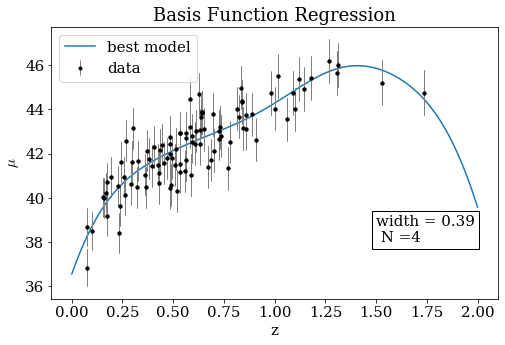

In [58]:
# best fit
basis_centers = np.linspace(0, 2, N_best)[:, np.newaxis]
basis = BasisFunctionRegression('gaussian', mu=basis_centers, sigma=sigma_best)
basis.fit(z_sample[:, np.newaxis], mu_sample, dmu)


# plot best fit
fig = plt.figure(figsize=(8,5))

yfit_basis = basis.predict(xgrid[:, np.newaxis])
plt.plot(xgrid, yfit_basis, label='best model')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.title('Basis Function Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1)
plt.legend()
plt.text(1.5, 38, 'width = '+str(np.round(sigma_best,2))+'\n N ='+str(N_best), bbox=dict(ec='k', fc='w'))
#plt.ylim(36, 50)

### Kernel regression

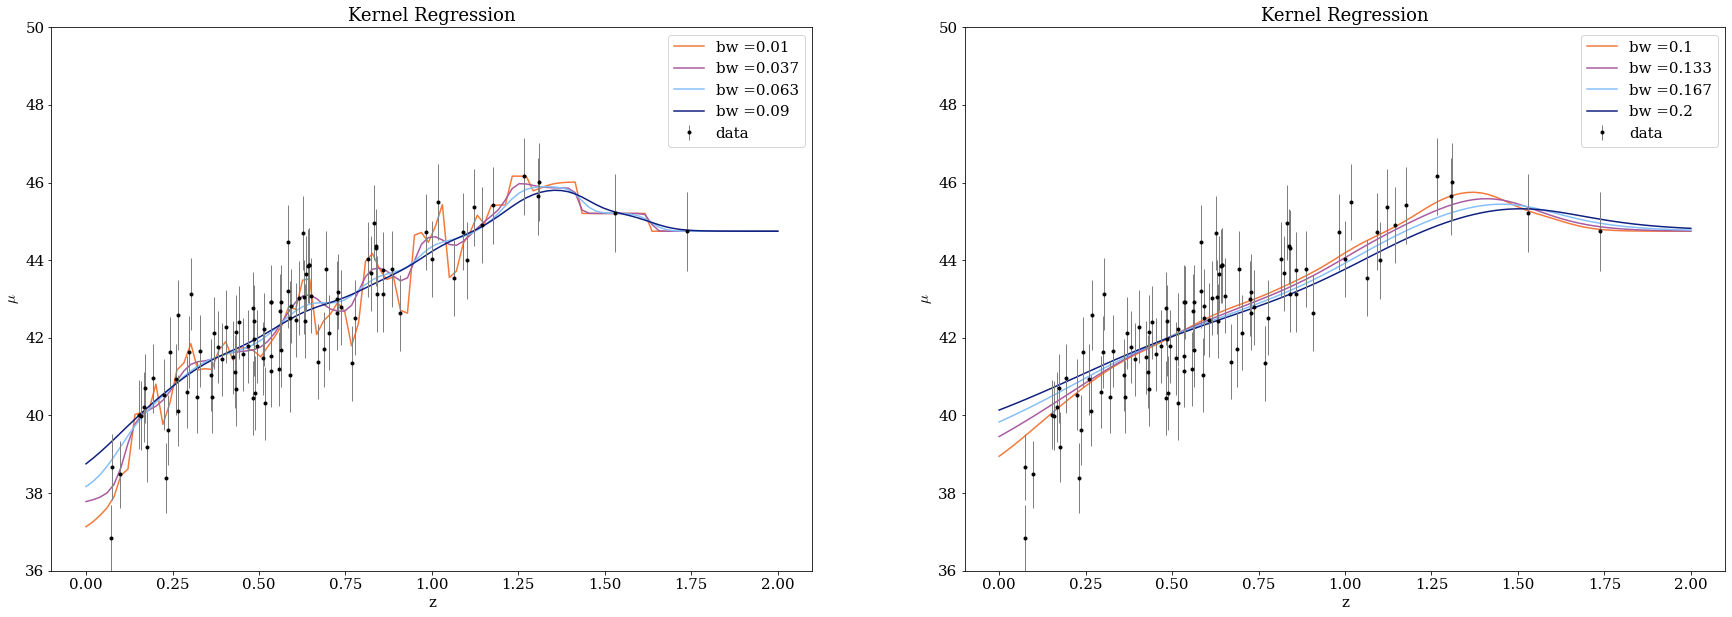

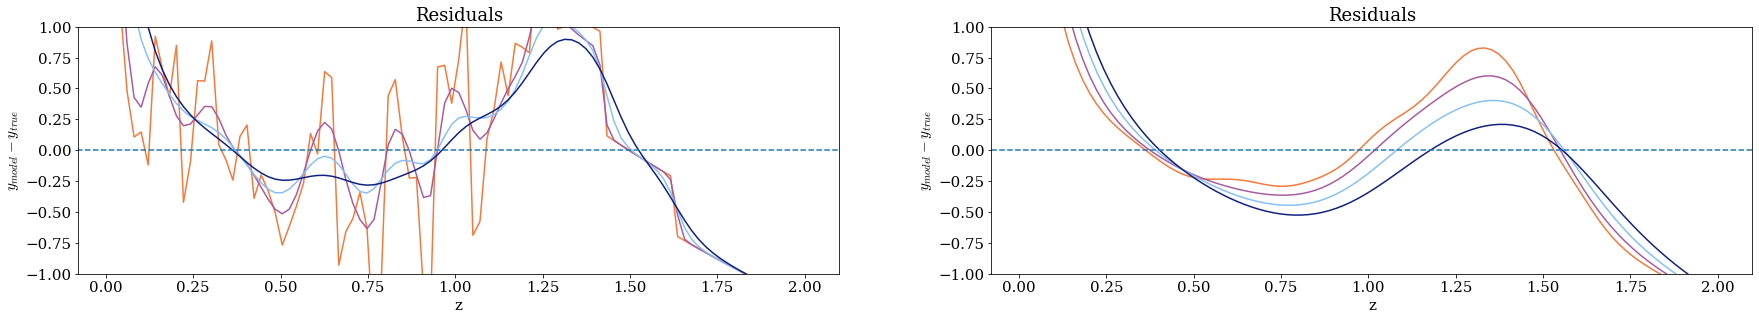

In [123]:
bwlow = np.linspace(0.01, 0.09, 4)
bwhigh = np.linspace(0.1, 0.2, 4)

fig = plt.figure(figsize=(30,10))

ax1 = plt.subplot(121)
for i in range(len(bwlow)):
    kernel = NadarayaWatson(kernel='gaussian', h=bwlow[i])
    kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_kernel = kernel.predict(xgrid[:, np.newaxis])
    plt.plot(xgrid, yfit_kernel, label='bw ='+str(round(bwlow[i],3)), color=color[i])
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.title('Kernel Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(36, 50)
plt.legend()


ax2 = plt.subplot(122)
for i in range(len(bwhigh)):
    kernel = NadarayaWatson(kernel='gaussian', h=bwhigh[i])
    kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_kernel = kernel.predict(xgrid[:, np.newaxis])
    plt.plot(xgrid, yfit_kernel, label='bw ='+str(round(bwhigh[i],3)), color=color[i])
    
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.title('Kernel Regression')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.ylim(36, 50)
plt.legend()


fig = plt.figure(figsize=(30,10))
ax3 = fig.add_subplot(221)
for i in range(len(bwlow)):
    kernel = NadarayaWatson(kernel='gaussian', h=bwlow[i])
    kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_kernel = kernel.predict(xgrid[:, np.newaxis])
    plt.plot(zgrid, yfit_kernel-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');


ax4 = fig.add_subplot(222)
for i in range(len(bwhigh)):
    kernel = NadarayaWatson(kernel='gaussian', h=bwhigh[i])
    kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
    yfit_kernel = kernel.predict(xgrid[:, np.newaxis])
    plt.plot(zgrid, yfit_kernel-mumodel, color=color[i])

plt.axhline(0, 3, 0, linestyle='--')
plt.ylim(-1,1)    
plt.ylabel(r'$y_{model}-y_{true}$')
plt.xlabel('z')
plt.title('Residuals');

##### Cross-validation

In [43]:
bw = np.linspace(0.01, 0.1, 100)    

trainerr_kernel = []
cverr_kernel = []

for b in bw:
    kernel = NadarayaWatson(kernel='gaussian', h=b)
    cverr, trainerr = errors_cv(z_sample[:, np.newaxis], mu_sample, dmu, kernel, 5, random_state=13)
    cverr_kernel.append(cverr)
    trainerr_kernel.append(trainerr)
    
bw_best = bw[cverr_kernel == min(cverr_kernel)][0]
print('best bw:', bw_best)

best bw: 0.06272727272727273


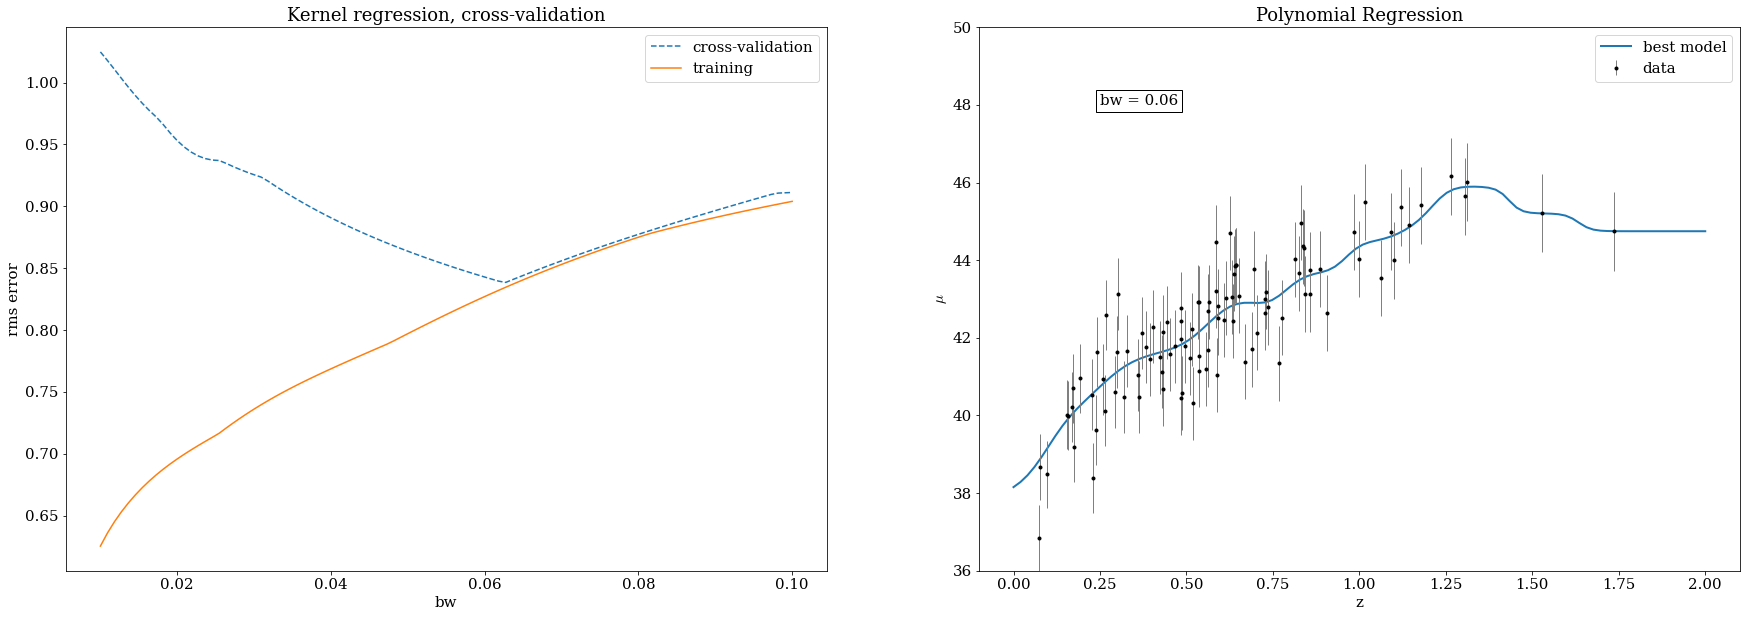

In [45]:
fig = plt.figure(figsize=(30,10))

# Plot cross-validation result
ax1 = plt.subplot(121)
plt.plot(bw, cverr_kernel, '--', label='cross-validation')
plt.plot(bw, trainerr_kernel, '-', label='training')
plt.xlabel('bw')
plt.ylabel('rms error')
plt.legend();
plt.title('Kernel regression, cross-validation');


# Plot best model
kernel = NadarayaWatson(kernel='gaussian', h=bw_best)
kernel.fit(z_sample[:, np.newaxis], mu_sample, dmu)
yfit = kernel.predict(xgrid.reshape(-1,1))

ax2 = plt.subplot(122)
ax2.plot(xgrid, yfit, label='best model', lw=2)  
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.legend()
plt.ylim(36, 50);
plt.text(0.25, 48, 'bw = '+str(round(bw_best,2)), bbox=dict(ec='k', fc='w'))
plt.title('Polynomial Regression')
plt.xlabel("z")
plt.ylabel("$\mu$");

### Learning curves

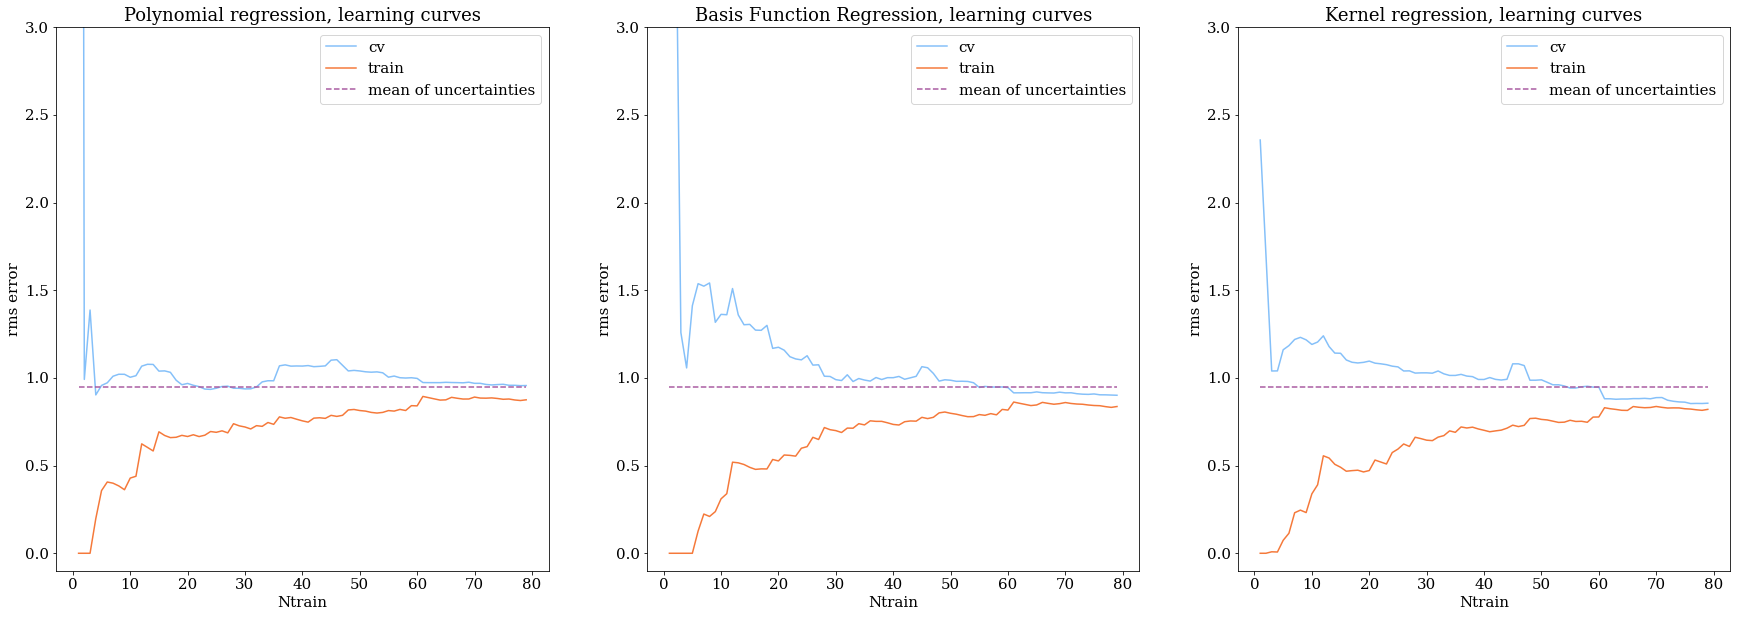

In [64]:
# Plot learning curve
X_train, X_cv, y_train, y_cv, dy_train, dy_cv = train_test_split(z_sample, mu_sample, dmu, test_size=20, 
                                                                 random_state=42)


fig = plt.figure(figsize=(30,10))


# polynomial regression
ax1 = plt.subplot(131)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, poly)
plt.title('Polynomial regression, learning curves')
plt.ylim(-0.1,3);


# basis function regression
ax2 = plt.subplot(132)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, basis)
plt.title('Basis Function Regression, learning curves')
plt.ylim(-0.1,3);


# kernel regression
ax3 = plt.subplot(133)
learning_curves(X_train, y_train, dy_train, X_cv, y_cv, dy_cv, kernel)
plt.title('Kernel regression, learning curves')
plt.ylim(-0.1,3);